In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import umap
import umap.plot

import scipy
import scipy.sparse as sp_sparse
from scipy.sparse import csr_matrix
import scanpy as sc
import anndata

from scipy.stats import ttest_ind
from scipy.stats import pearsonr

In [128]:
save_dir ='figures/'
results_dir = '../results'
ref_dir = '../../data/'
ref_names = ['NGJ', 'HECA']
reps = ['', '_switch']
ref_dataset_name = 'js'
ref_assignment_dataset_name = 'SEACell_assignments'
bulk_dataset_name = 'exp_metadata_cleaned_js'
bulk_split_suffix = ''

model = 'LogNorm'
DATES = ['2024-07-12', '2024-07-13', '2024-07-14']

In [129]:
# read data, try different dates
def read_df(func_filename, str_bf, str_af):
	try:
		filename = func_filename(str_bf, str_af, DATES[0])
		return pd.read_csv(filename, index_col=0)
	except:
		try:
			filename = func_filename(str_bf, str_af, DATES[1])
			return pd.read_csv(filename, index_col=0)
		except:
			filename = func_filename(str_bf, str_af, DATES[2])
			return pd.read_csv(filename, 	index_col=0)

### Compare different age groups

In [145]:
# read cell fractions
suffixes = ["le29", "le35", "le40", "ge40"]

# create empty dataframe
results_age_fractions = {}

def func_filename(str_bf, str_af, date):
	return f'{str_bf}{date}{str_af}'

for name in ref_names:
	for rep in reps:
		tmp_dfs = []
		for suff in suffixes:
			for cv in range(5):
				str_bf = f'{results_dir}_{name}/{bulk_dataset_name}_age{suff}/{model}/cell_prob_'
				str_af = f'_js{rep}{cv}.csv'
				age_cell_fractions = read_df(func_filename, str_bf, str_af)

				# take the mean of days 2-4
				age_cell_fractions = age_cell_fractions.iloc[:, 1:4].mean(axis=1)

				age_cell_fractions['age'] = suff
				age_cell_fractions['cv'] = cv

				tmp_dfs.append(age_cell_fractions)

		results_age_fractions[f'{name}{rep}'] = pd.concat([pd.DataFrame(data=tmp_dfs)])

In [154]:
# add mean, std, min, max across CVs
agg_results_age_fractions = {}
for name in ref_names:
	for rep in reps:
		tmp_df = results_age_fractions[f'{name}{rep}'].iloc[:, :-1].groupby('age').agg(['mean', 'std', 'min', 'max'])
		agg_results_age_fractions[f'{name}{rep}'] = tmp_df
		# save to csv
		tmp_df.to_csv(f'{save_dir}age_cell_fractions_{name}{rep}.csv')

In [124]:
J14 = results_age_fractions['NGJ_switch'][['age', 'cv', 'SEACell-14']]
J14['ref'] = ['NGJ'] * J14.shape[0]
# rename column
J14 = J14.rename(columns={'SEACell-14': 'SEACell'})

H18 = results_age_fractions['HECA_switch'][['age', 'cv', 'SEACell-18']]
H18['ref'] = ['HECA'] * H18.shape[0]
# rename column
H18 = H18.rename(columns={'SEACell-18': 'SEACell'})

# merge
H18J14 = pd.concat([J14, H18])

/var/folders/mp/0ylvhbys7zl0gsbx35x33lfw0000gp/T/ipykernel_15279/70500559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  J14['ref'] = ['NGJ'] * J14.shape[0]
/var/folders/mp/0ylvhbys7zl0gsbx35x33lfw0000gp/T/ipykernel_15279/70500559.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H18['ref'] = ['HECA'] * H18.shape[0]


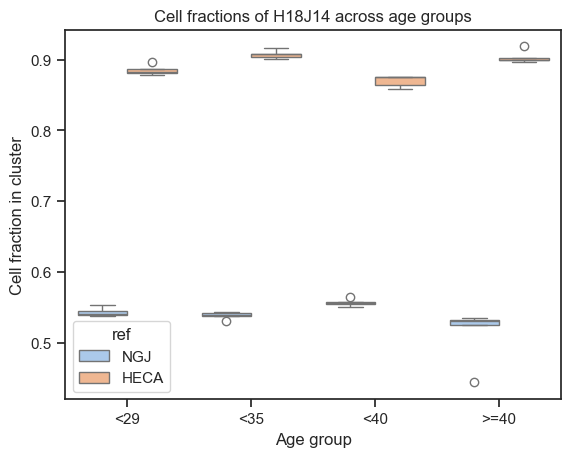

In [155]:
# create a boxplot with x-axis as age group (suffixes) and y-axis as cell fractions in cluster 14 of NGJ reference dataset
sns.set(style="ticks", palette="pastel")
sns.boxplot(x='age', y='SEACell', data=H18J14, hue='ref')
# label x-ticks
plt.xticks([0, 1, 2, 3],['<29', '<35', '<40', '>=40'])
plt.ylabel('Cell fraction in cluster')
plt.xlabel('Age group')
plt.title('Cell fractions of H18J14 across age groups')
plt.show()

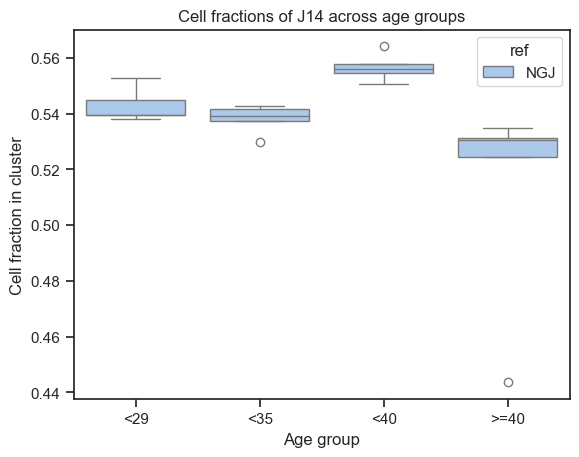

In [156]:
# only plot J14
J14 = H18J14[H18J14['ref'] == 'NGJ']
sns.set(style="ticks", palette="pastel")
sns.boxplot(x='age', y='SEACell', data=J14, hue='ref')
# label x-ticks
plt.xticks([0, 1, 2, 3],['<29', '<35', '<40', '>=40'])
plt.ylabel('Cell fraction in cluster')
plt.xlabel('Age group')
plt.title('Cell fractions of J14 across age groups')
plt.show()

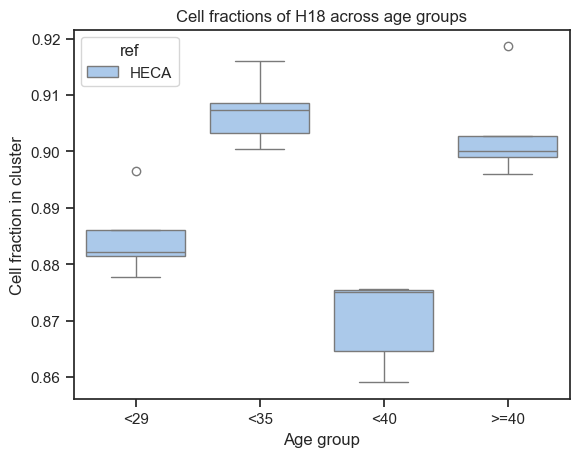

In [157]:
# only plot H18
H18 = H18J14[H18J14['ref'] == 'HECA']
sns.set(style="ticks", palette="pastel")
sns.boxplot(x='age', y='SEACell', data=H18, hue='ref')
# label x-ticks
plt.xticks([0, 1, 2, 3],['<29', '<35', '<40', '>=40'])
plt.ylabel('Cell fraction in cluster')
plt.xlabel('Age group')
plt.title('Cell fractions of H18 across age groups')
plt.show()

In [126]:
# calculate correlation and p-value

# average cell fractions across CVs
H18J14_avg = H18J14.groupby(['age', 'ref']).mean().reset_index()
H18J14_avg

# calculate correlation
corr, pval = pearsonr(H18J14_avg[H18J14_avg['ref'] == 'NGJ']['SEACell'], H18J14_avg[H18J14_avg['ref'] == 'HECA']['SEACell'])
corr, pval

(-0.7702757806979645, 0.22972421930203546)

In [121]:
J13 = results_age_fractions['NGJ_switch'][['age', 'cv', 'SEACell-13']]
J13['ref'] = ['NGJ'] * J13.shape[0]
# rename column
J13 = J13.rename(columns={'SEACell-13': 'SEACell'})

H8 = results_age_fractions['HECA_switch'][['age', 'cv', 'SEACell-8']]
H8['ref'] = ['HECA'] * H8.shape[0]
# rename column
H8 = H8.rename(columns={'SEACell-8': 'SEACell'})

# merge
H8J13 = pd.concat([J13, H8])

/var/folders/mp/0ylvhbys7zl0gsbx35x33lfw0000gp/T/ipykernel_15279/2262291088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  J13['ref'] = ['NGJ'] * J13.shape[0]
/var/folders/mp/0ylvhbys7zl0gsbx35x33lfw0000gp/T/ipykernel_15279/2262291088.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H8['ref'] = ['HECA'] * H8.shape[0]


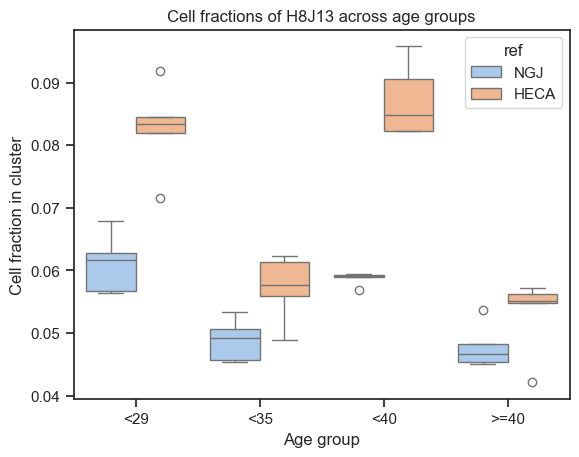

In [122]:
# create a boxplot with x-axis as age group (suffixes) and y-axis as cell fractions in cluster 14 of NGJ reference dataset
sns.set(style="ticks", palette="pastel")
sns.boxplot(x='age', y='SEACell', data=H8J13, hue='ref')
# label x-ticks
plt.xticks([0, 1, 2, 3],['<29', '<35', '<40', '>=40'])
plt.ylabel('Cell fraction in cluster')
plt.xlabel('Age group')
plt.title('Cell fractions of H8J13 across age groups')
plt.show()

Text(0.5, 1.0, 'Cell fractions of J13 across age groups')

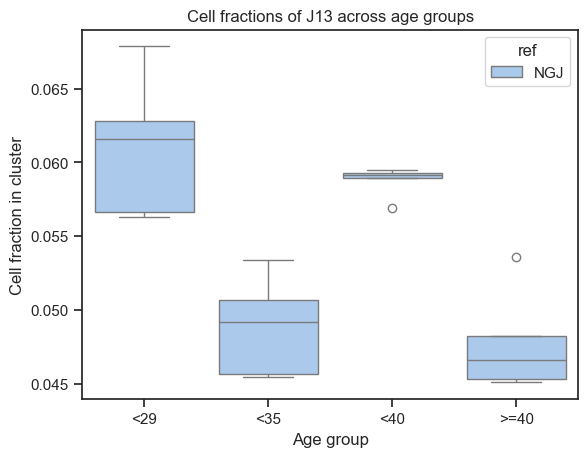

In [158]:
# only plot J13
J13 = H8J13[H8J13['ref'] == 'NGJ']
sns.set(style="ticks", palette="pastel")
sns.boxplot(x='age', y='SEACell', data=J13, hue='ref')
# label x-ticks
plt.xticks([0, 1, 2, 3],['<29', '<35', '<40', '>=40'])
plt.ylabel('Cell fraction in cluster')
plt.xlabel('Age group')
plt.title('Cell fractions of J13 across age groups')

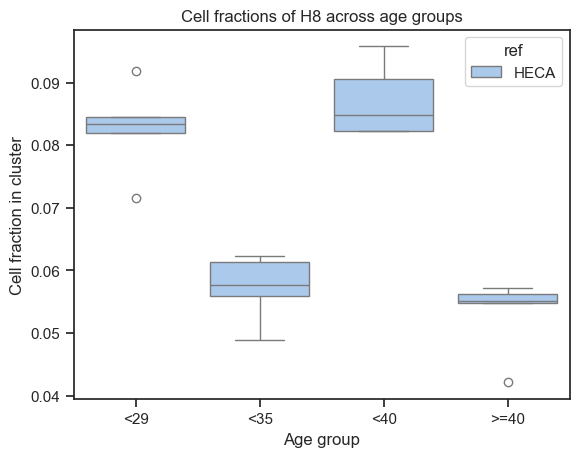

In [159]:
# only plot H8
H8 = H8J13[H8J13['ref'] == 'HECA']
sns.set(style="ticks", palette="pastel")
sns.boxplot(x='age', y='SEACell', data=H8, hue='ref')
# label x-ticks
plt.xticks([0, 1, 2, 3],['<29', '<35', '<40', '>=40'])
plt.ylabel('Cell fraction in cluster')
plt.xlabel('Age group')
plt.title('Cell fractions of H8 across age groups')
plt.show()

In [123]:
# calculate correlation and p-value

# average cell fractions across CVs
H18J14_avg = H18J14.groupby(['age', 'ref']).mean().reset_index()
H18J14_avg

# calculate correlation
corr, pval = pearsonr(H18J14_avg[H18J14_avg['ref'] == 'NGJ']['SEACell'], H18J14_avg[H18J14_avg['ref'] == 'HECA']['SEACell'])
corr, pval

(0.9700227328041865, 0.029977267195813617)

### Compare different birth control

In [44]:
# read cell fractions
suffixes = ["bcno", "bcp", "bcep"]
dates = {"bcno":  DATE, "bcp":  DATE, "bcep": DATE2}
results_bc_fractions = {}

for name in ref_names:
	for rep in reps:
		bc_cell_fractions_mean = {}
		for suff in suffixes:
			try:
				bc_cell_fractions = pd.read_csv(f'{results_dir}_{name}/{bulk_dataset_name}_{suff}/{model}/cell_prob_{DATE}_js{rep}.csv', index_col=0)
			except:
				bc_cell_fractions = pd.read_csv(f'{results_dir}_{name}/{bulk_dataset_name}_{suff}/{model}/cell_prob_{DATE2}_js{rep}.csv', index_col=0)
			bc_cell_fractions_mean[suff] = bc_cell_fractions.iloc[:, 1:4].mean(axis=1)

		results_bc_fractions[f'{name}{rep}'] = np.vstack([bc_cell_fractions_mean[suff].values for suff in suffixes]).T

results_bc_fractions.keys()

dict_keys(['NGJ', 'NGJ_switch', 'HECA', 'HECA_switch'])

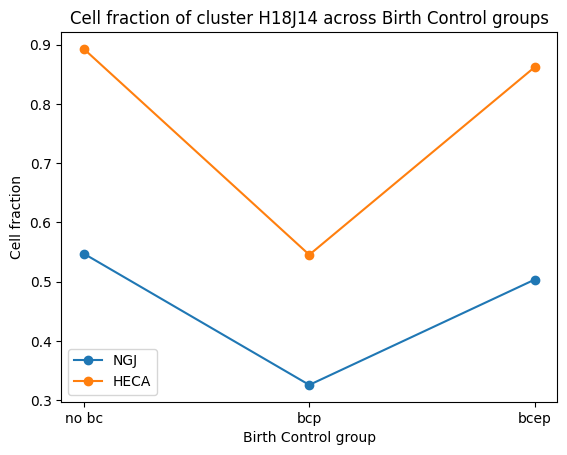

In [113]:
# plot cluster 14 and 18 across ages
plt.plot(results_bc_fractions['NGJ_switch'][14], label='NGJ', marker='o')
plt.plot(results_bc_fractions['HECA_switch'][18], label='HECA', marker='o')
plt.xticks([0, 1, 2], ["no bc", "bcp", "bcep"])
plt.ylabel('Cell fraction')
plt.xlabel('Birth Control group')
plt.title('Cell fraction of cluster H18J14 across Birth Control groups')
plt.legend()
plt.show()

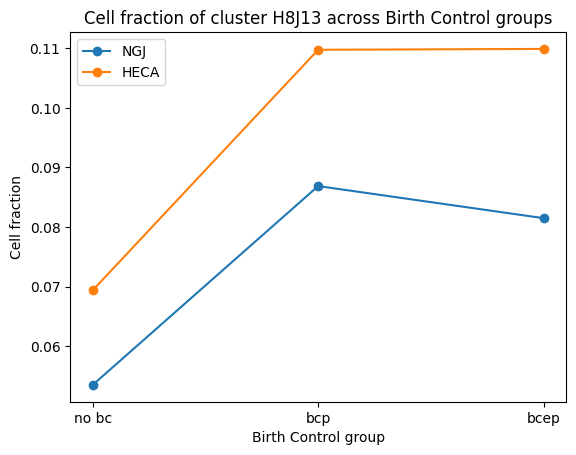

In [112]:
# plot cluster 14 and 18 across ages
plt.plot(results_bc_fractions['NGJ_switch'][13], label='NGJ', marker='o')
plt.plot(results_bc_fractions['HECA_switch'][8], label='HECA', marker='o')
plt.xticks([0, 1, 2], ["no bc", "bcp", "bcep"])
plt.ylabel('Cell fraction')
plt.xlabel('Birth Control group')
plt.title('Cell fraction of cluster H8J13 across Birth Control groups')
plt.legend()
plt.show()

### Compare Endometriosis cases

In [47]:
# read cell fractions
suffixes = ["case", "sus", "control"]
results_endo_fractions = {}

for name in ref_names:
	for rep in reps:
		endo_cell_fractions_mean = {}
		for suff in suffixes:
			try:
				endo_cell_fractions = pd.read_csv(f'{results_dir}_{name}/{bulk_dataset_name}_{suff}/{model}/cell_prob_{DATE}_js{rep}.csv', index_col=0)
			except:
				endo_cell_fractions = pd.read_csv(f'{results_dir}_{name}/{bulk_dataset_name}_{suff}/{model}/cell_prob_{DATE2}_js{rep}.csv', index_col=0)
			endo_cell_fractions_mean[suff] = endo_cell_fractions.iloc[:, 1:4].mean(axis=1)

		results_endo_fractions[f'{name}{rep}'] = np.vstack([endo_cell_fractions_mean[suff].values for suff in suffixes]).T

results_endo_fractions.keys()

dict_keys(['NGJ', 'NGJ_switch', 'HECA', 'HECA_switch'])

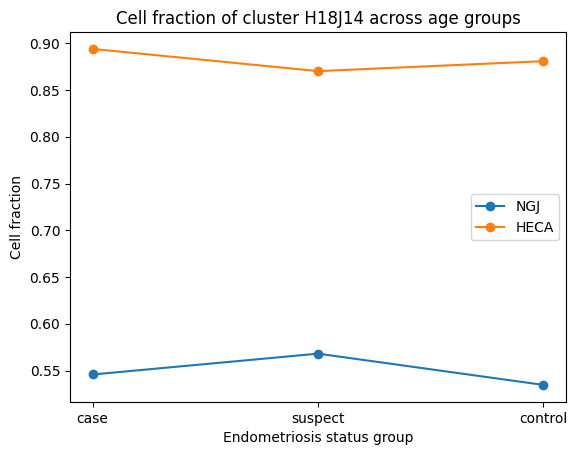

In [48]:
# plot cluster 14 and 18 across ages
plt.plot(results_endo_fractions['NGJ_switch'][14], label='NGJ', marker='o')
plt.plot(results_endo_fractions['HECA_switch'][18], label='HECA', marker='o')
plt.xticks([0, 1, 2], ["case", "suspect", "control"])
plt.ylabel('Cell fraction')
plt.xlabel('Endometriosis status group')
plt.title('Cell fraction of cluster H18J14 across age groups')
plt.legend()
plt.show()

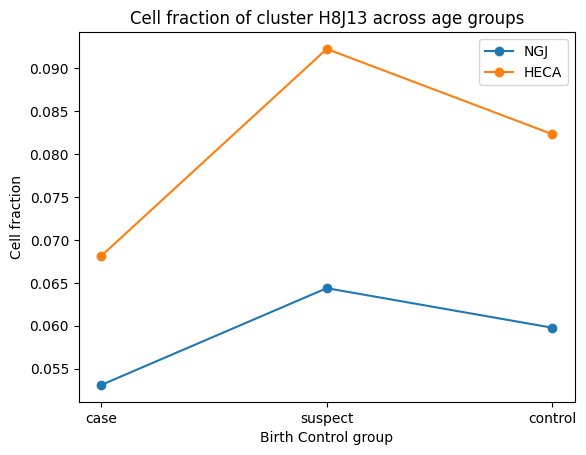

In [51]:
# plot cluster 14 and 18 across ages
plt.plot(results_endo_fractions['NGJ_switch'][13], label='NGJ', marker='o')
plt.plot(results_endo_fractions['HECA_switch'][8], label='HECA', marker='o')
plt.xticks([0, 1, 2], ["case", "suspect", "control"])
plt.ylabel('Cell fraction')
plt.xlabel('Birth Control group')
plt.title('Cell fraction of cluster H8J13 across age groups')
plt.legend()
plt.show()

### Plot age progression for different endometriosis status

In [56]:
# read cell fractions
ages = [i for i in range(4)]
endos = [0, 0.5, 1]
results_endo_fractions = {}

for name in ref_names:
	for rep in reps:
		for endo in endos:
			endo_cell_fractions_mean = {}
			for age in ages:
				suff = f'endo{endo}_age{age}'
				try:
					endo_cell_fractions = pd.read_csv(f'{results_dir}_{name}/{bulk_dataset_name}_{suff}/{model}/cell_prob_{DATE}_js{rep}.csv', index_col=0)
				except:
					endo_cell_fractions = pd.read_csv(f'{results_dir}_{name}/{bulk_dataset_name}_{suff}/{model}/cell_prob_{DATE2}_js{rep}.csv', index_col=0)
				endo_cell_fractions_mean[suff] = endo_cell_fractions.iloc[:, 1:4].mean(axis=1)

			results_endo_fractions[f'{name}{rep}{endo}'] = np.vstack([endo_cell_fractions_mean[suff].values for suff in endo_cell_fractions_mean.keys()]).T

results_endo_fractions.keys()

dict_keys(['NGJ0', 'NGJ0.5', 'NGJ1', 'NGJ_switch0', 'NGJ_switch0.5', 'NGJ_switch1', 'HECA0', 'HECA0.5', 'HECA1', 'HECA_switch0', 'HECA_switch0.5', 'HECA_switch1'])

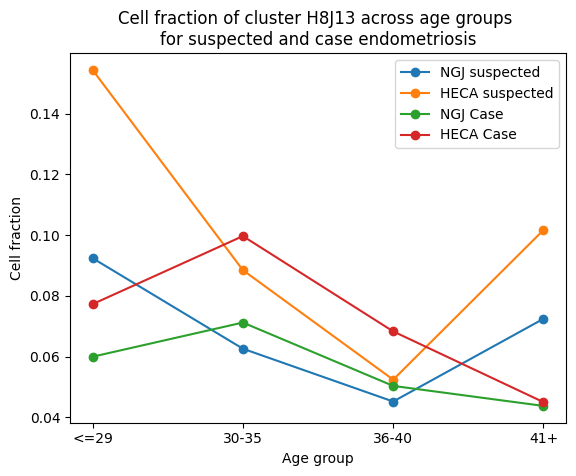

In [121]:
# plot cluster 14 and 18 across ages
plt.plot(results_endo_fractions['NGJ_switch0.5'][13], label='NGJ suspected', marker='o')
plt.plot(results_endo_fractions['HECA_switch0.5'][8], label='HECA suspected', marker='o')
plt.plot(results_endo_fractions['NGJ_switch1'][13], label='NGJ Case', marker='o')
plt.plot(results_endo_fractions['HECA_switch1'][8], label='HECA Case', marker='o')
plt.xticks([0, 1, 2, 3], [f'{age}' for age in ["<=29", "30-35", "36-40", "41+"]])
plt.ylabel('Cell fraction')
plt.xlabel('Age group')
plt.title('Cell fraction of cluster H8J13 across age groups \nfor suspected and case endometriosis')
plt.legend()
plt.show()

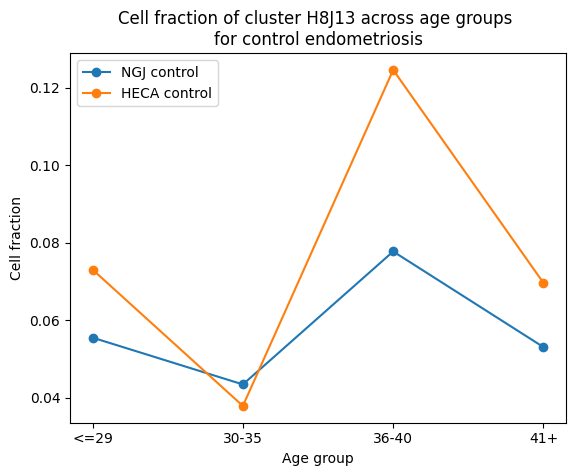

In [123]:
# plot cluster 14 and 18 across ages
plt.plot(results_endo_fractions['NGJ_switch0'][13], label='NGJ control', marker='o')
plt.plot(results_endo_fractions['HECA_switch0'][8], label='HECA control', marker='o')
plt.xticks([0, 1, 2, 3], [f'{age}' for age in ["<=29", "30-35", "36-40", "41+"]])
plt.ylabel('Cell fraction')
plt.xlabel('Age group')
plt.title('Cell fraction of cluster H8J13 across age groups \nfor control endometriosis')
plt.legend()
plt.show()

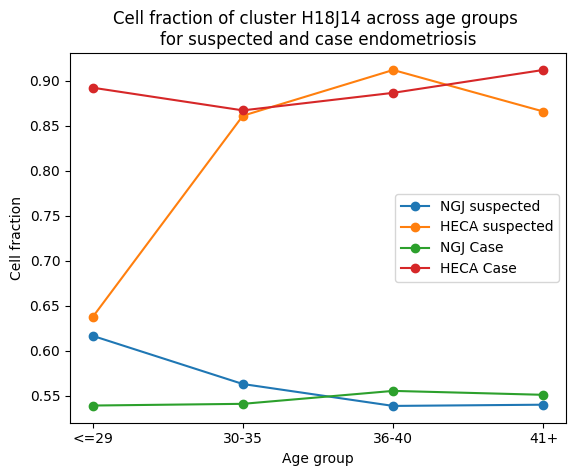

In [122]:
# plot cluster 14 and 18 across ages
plt.plot(results_endo_fractions['NGJ_switch0.5'][14], label='NGJ suspected', marker='o')
plt.plot(results_endo_fractions['HECA_switch0.5'][18], label='HECA suspected', marker='o')
plt.plot(results_endo_fractions['NGJ_switch1'][14], label='NGJ Case', marker='o')
plt.plot(results_endo_fractions['HECA_switch1'][18], label='HECA Case', marker='o')
plt.xticks([0, 1, 2, 3], [f'{age}' for age in ["<=29", "30-35", "36-40", "41+"]])
plt.ylabel('Cell fraction')
plt.xlabel('Age group')
plt.title('Cell fraction of cluster H18J14 across age groups \nfor suspected and case endometriosis')
plt.legend()
plt.show()

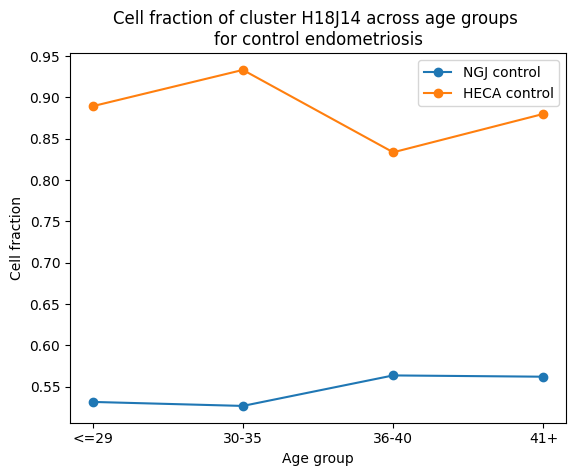

In [124]:
# plot cluster 14 and 18 across ages
plt.plot(results_endo_fractions['NGJ_switch0'][14], label='NGJ control', marker='o')
plt.plot(results_endo_fractions['HECA_switch0'][18], label='HECA control', marker='o')
plt.xticks([0, 1, 2, 3], [f'{age}' for age in ["<=29", "30-35", "36-40", "41+"]])
plt.ylabel('Cell fraction')
plt.xlabel('Age group')
plt.title('Cell fraction of cluster H18J14 across age groups \nfor control endometriosis')
plt.legend()
plt.show()

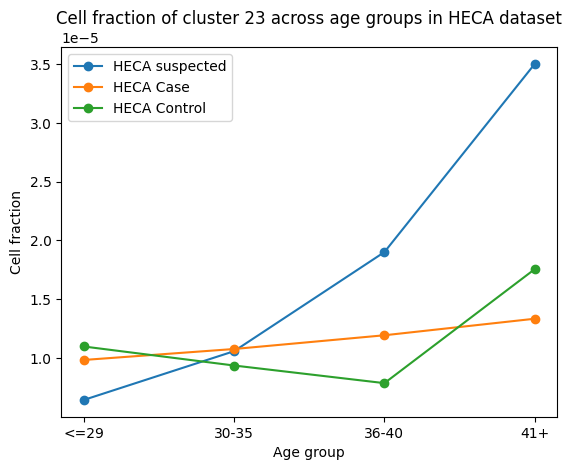

In [71]:
# plot cluster 14 and 18 across ages
plt.plot(results_endo_fractions['HECA_switch0.5'][23], label='HECA suspected', marker='o')
plt.plot(results_endo_fractions['HECA_switch1'][23], label='HECA Case', marker='o')
plt.plot(results_endo_fractions['HECA_switch0'][23], label='HECA Control', marker='o')
plt.xticks([0, 1, 2, 3], [f'{age}' for age in ["<=29", "30-35", "36-40", "41+"]])
plt.ylabel('Cell fraction')
plt.xlabel('Age group')
plt.title('Cell fraction of cluster 23 across age groups in HECA dataset')
plt.legend()
plt.show()

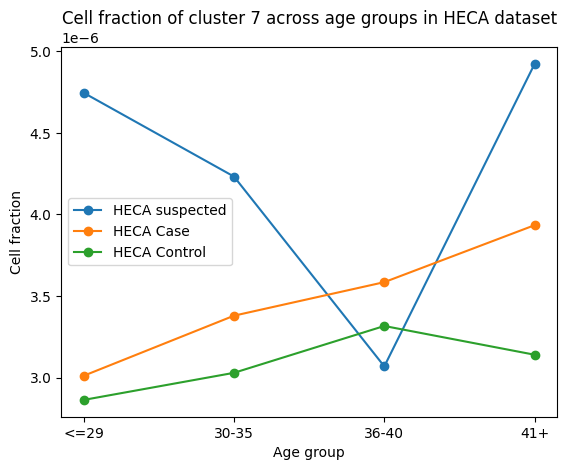

In [94]:
# plot cluster 14 and 18 across ages
plt.plot(results_endo_fractions['HECA_switch0.5'][7], label='HECA suspected', marker='o')
plt.plot(results_endo_fractions['HECA_switch1'][7], label='HECA Case', marker='o')
plt.plot(results_endo_fractions['HECA_switch0'][7], label='HECA Control', marker='o')
plt.xticks([0, 1, 2, 3], [f'{age}' for age in ["<=29", "30-35", "36-40", "41+"]])
plt.ylabel('Cell fraction')
plt.xlabel('Age group')
plt.title('Cell fraction of cluster 7 across age groups in HECA dataset')
plt.legend()
plt.show()

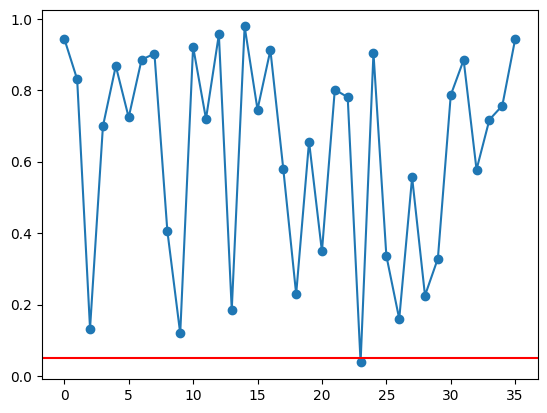

In [92]:
ages= [0, 1, 2, 3]

correlations = []
for i in range(results_endo_fractions['HECA_switch0'].shape[0]):
	correlations.append(np.corrcoef(ages, results_endo_fractions['HECA_switch0.5'][i, :])[0, 1])

pvals = []
for i in range(results_endo_fractions['HECA_switch0'].shape[0]):
	pvals.append(scipy.stats.pearsonr(ages, results_endo_fractions['HECA_switch0.5'][i, :])[1])

plt.plot(pvals, marker='o')
# plot line at 0.05
plt.axhline(y=0.05, color='r', linestyle='-')

Text(0.5, 1.0, 'Cell fraction of cluster 8 and 13 across age groups in HECA dataset')

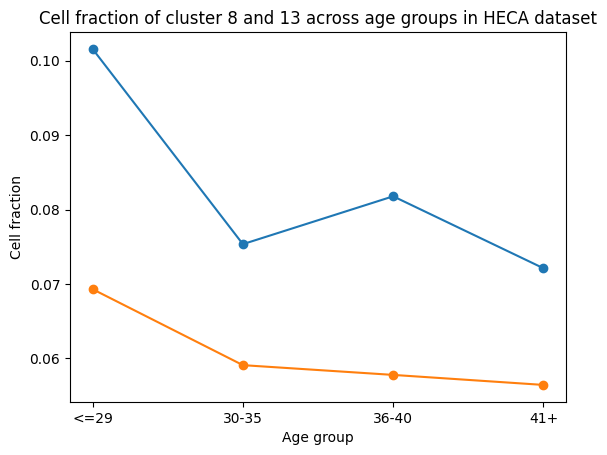

In [109]:
c8 = np.vstack([results_endo_fractions[f'HECA_switch{status}'][8] for status in [0, 0.5, 1]])
c8_mean = c8.mean(axis=0)

c13 = np.vstack([results_endo_fractions[f'NGJ_switch{status}'][13] for status in [0, 0.5, 1]])
c13_mean = c13.mean(axis=0)

plt.plot(c8_mean, label='HECA cluster 8', marker='o')
plt.plot(c13_mean, label='NGJ cluster 13', marker='o')
plt.xticks([0, 1, 2, 3], [f'{age}' for age in ["<=29", "30-35", "36-40", "41+"]])
plt.ylabel('Cell fraction')
plt.xlabel('Age group')
plt.title('Cell fraction of cluster 8 and 13 across age groups in HECA dataset')

Text(0.5, 1.0, 'Cell fraction of cluster 18 and 14 across age groups in HECA dataset')

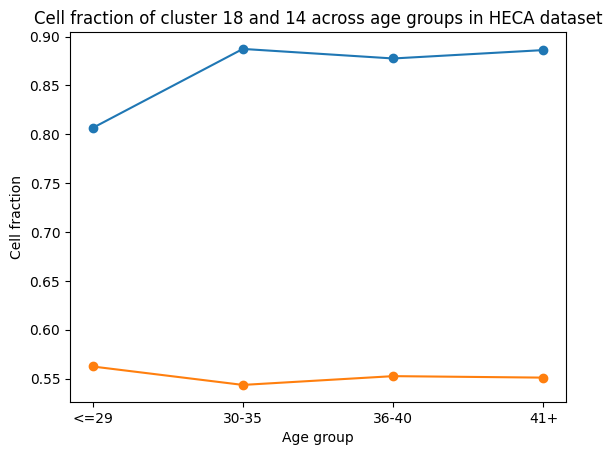

In [111]:
c18 = np.vstack([results_endo_fractions[f'HECA_switch{status}'][18] for status in [0, 0.5, 1]])
c18_mean = c18.mean(axis=0)

c14 = np.vstack([results_endo_fractions[f'NGJ_switch{status}'][14] for status in [0, 0.5, 1]])
c14_mean = c14.mean(axis=0)

plt.plot(c18_mean, label='HECA cluster 18', marker='o')
plt.plot(c14_mean, label='NGJ cluster 14', marker='o')
plt.xticks([0, 1, 2, 3], [f'{age}' for age in ["<=29", "30-35", "36-40", "41+"]])
plt.ylabel('Cell fraction')
plt.xlabel('Age group')
plt.title('Cell fraction of cluster 18 and 14 across age groups in HECA dataset')